In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Steps** <p>
Step 1: Load Dataset <p>
Step 2: Transform the Dataset <p>
Step 3: Create Model <p>
Step 4: Train Model <p>
Step 5: Save the Model <p>
Step 6: Load the Model <p>
Step 7: Predict the Image <p>
Step 8: Show the result

# **Step 1: Load Dataset**

In [ ]:
cp -av /content/drive/MyDrive/Dataset/ImageClassification . .

'/content/drive/MyDrive/Dataset/ImageClassification' -> './ImageClassification'
'/content/drive/MyDrive/Dataset/ImageClassification/classify.py' -> './ImageClassification/classify.py'
'/content/drive/MyDrive/Dataset/ImageClassification/train.py' -> './ImageClassification/train.py'
'/content/drive/MyDrive/Dataset/ImageClassification/pyimagesearch' -> './ImageClassification/pyimagesearch'
'/content/drive/MyDrive/Dataset/ImageClassification/pyimagesearch/__init__.py' -> './ImageClassification/pyimagesearch/__init__.py'
'/content/drive/MyDrive/Dataset/ImageClassification/pyimagesearch/smallervggnet.py' -> './ImageClassification/pyimagesearch/smallervggnet.py'
'/content/drive/MyDrive/Dataset/ImageClassification/pyimagesearch/.DS_Store' -> './ImageClassification/pyimagesearch/.DS_Store'
'/content/drive/MyDrive/Dataset/ImageClassification/pyimagesearch/__pycache__' -> './ImageClassification/pyimagesearch/__pycache__'
'/content/drive/MyDrive/Dataset/ImageClassification/pyimagesearch/__pycache_

In [ ]:
cp -av /content/drive/MyDrive/Dataset/DatasetSide . .

'/content/drive/MyDrive/Dataset/DatasetSide' -> './DatasetSide'
'/content/drive/MyDrive/Dataset/DatasetSide/Rear' -> './DatasetSide/Rear'
'/content/drive/MyDrive/Dataset/DatasetSide/Rear/Rear (54).jpg' -> './DatasetSide/Rear/Rear (54).jpg'
'/content/drive/MyDrive/Dataset/DatasetSide/Rear/Rear (11).jpg' -> './DatasetSide/Rear/Rear (11).jpg'
'/content/drive/MyDrive/Dataset/DatasetSide/Rear/Rear (6).JPEG' -> './DatasetSide/Rear/Rear (6).JPEG'
'/content/drive/MyDrive/Dataset/DatasetSide/Rear/Rear (14).jpg' -> './DatasetSide/Rear/Rear (14).jpg'
'/content/drive/MyDrive/Dataset/DatasetSide/Rear/Rear (5).jpeg' -> './DatasetSide/Rear/Rear (5).jpeg'
'/content/drive/MyDrive/Dataset/DatasetSide/Rear/Rear (36).JPEG' -> './DatasetSide/Rear/Rear (36).JPEG'
'/content/drive/MyDrive/Dataset/DatasetSide/Rear/Rear (30).JPEG' -> './DatasetSide/Rear/Rear (30).JPEG'
'/content/drive/MyDrive/Dataset/DatasetSide/Rear/Rear (19).JPEG' -> './DatasetSide/Rear/Rear (19).JPEG'
'/content/drive/MyDrive/Dataset/DatasetS

In [ ]:
!unzip  "Dataset.zip"

# **Step 2: Importing Important Libraries**

In [ ]:
#Import lib
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
import matplotlib.pyplot as plt
# from pyimagesearch.smallervggnet import SmallerVGGNet
from imutils import paths
import numpy as np
import argparse
import random
import pickle
import cv2
import os

In [ ]:
# initialize the number of epochs to train for, initial learning rate,
# batch size, and image dimensions
EPOCHS = 50
INIT_LR = 1e-3
BS = 32
IMAGE_DIMS = (96, 96, 3)


In [ ]:
imagePaths = sorted(list(paths.list_images("DatasetSide")))
random.seed(42)
random.shuffle(imagePaths)

In [ ]:
data = []
labels = []

# loop over the input images
for imagePath in imagePaths:
	# load the image, pre-process it, and store it in the data list
	image = cv2.imread(imagePath)
	image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
	image = img_to_array(image)
	data.append(image)

	# extract set of class labels from the image path and update the
	# labels list
	l = label = imagePath.split(os.path.sep)[-2].split("_")
	labels.append(l)


### To check the total number of images present in the dataset

In [ ]:
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print("[INFO] data matrix: {} images ({:.2f}MB)".format(
	len(imagePaths), data.nbytes / (1024 * 1000.0)))

# binarize the labels using scikit-learn's special multi-label
# binarizer implementation
print("[INFO] class labels:")
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels)


[INFO] data matrix: 466 images (100.66MB)
[INFO] class labels:


# **Checking the Labels**

In [ ]:
# loop over each of the possible class labels and show them
for (i, label) in enumerate(mlb.classes_):
	print("{}. {}".format(i + 1, label))


1. Front
2. Rear
3. Side Car


# **Train-Test Split**

In [ ]:
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.2, random_state=42)

# **Data Augmentation**

### Generated a data augmentation inorder to increase the amount of dataset and avoid overfitting

In [ ]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
	horizontal_flip=True, fill_mode="nearest")

# **Creating a TenLayerNetwork Model**

### Added activation function as RELU

In [ ]:
def threelayernetwork(width, height, depth, classes, finalAct="softmax"):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1

		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1

		# CONV => RELU => POOL
		model.add(Conv2D(32, (3, 3), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(3, 3)))
		model.add(Dropout(0.25))

		# (CONV => RELU) * 2 => POOL
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# (CONV => RELU) * 2 => POOL
		model.add(Conv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# first (and only) set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(1024))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation(finalAct))

		# return the constructed network architecture
		return model

In [ ]:
model = threelayernetwork(
	width=IMAGE_DIMS[1], height=IMAGE_DIMS[0],
	depth=IMAGE_DIMS[2], classes=len(mlb.classes_),
	finalAct="softmax")


# **Gradient Estimation**

In [ ]:
# initialize the optimizer (SGD is sufficient)
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)

# **Cost Function**

In [ ]:
# compile the model using binary cross-entropy rather than
# categorical cross-entropy -- this may seem counterintuitive for
# multi-label classification, but keep in mind that the goal here
# is to treat each output label as an independent Bernoulli
# distribution
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

In [ ]:
H = model.fit_generator(
	aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY),
	steps_per_epoch=len(trainX) // BS,
	epochs=EPOCHS, verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/50
11/11 [==============================] - 14s 179ms/step - loss: 2.3341 - accuracy: 0.3971 - val_loss: 1.3504 - val_accuracy: 0.4043
Epoch 2/50
11/11 [==============================] - 1s 117ms/step - loss: 2.2133 - accuracy: 0.4794 - val_loss: 1.2612 - val_accuracy: 0.4255
Epoch 3/50
11/11 [==============================] - 1s 117ms/step - loss: 1.6702 - accuracy: 0.5176 - val_loss: 1.3040 - val_accuracy: 0.4255
Epoch 4/50
11/11 [==============================] - 1s 123ms/step - loss: 1.4879 - accuracy: 0.5029 - val_loss: 3.0047 - val_accuracy: 0.4255
Epoch 5/50
11/11 [==============================] - 1s 116ms/step - loss: 1.2418 - accuracy: 0.5794 - val_loss: 4.8822 - val_accuracy: 0.4255
Epoch 6/50
11/11 [==============================] - 1s 115ms/step - loss: 1.1488 - accuracy: 0.5706 - val_loss: 3.0056 - val_accuracy: 0.4255
Epoch 7/50
11/11 [==============================] - 1s 116ms/step - loss: 1.0752 - accuracy: 0.6118 - val_loss: 5.9906 - val_accuracy: 0.4255
Epoch

In [ ]:
print("[INFO] serializing network...")
model.save("Car.model")

[INFO] serializing network...
INFO:tensorflow:Assets written to: Car.model/assets


In [ ]:
model.save_weights("sidemodel.h5")
print("Saved model to disk")

Saved model to disk


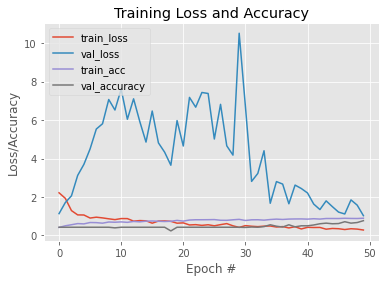

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
# plt.savefig(args["plot"])

In [ ]:
f = open("mlb.pickle", "wb")
f.write(pickle.dumps(mlb))
f.close()


Test the model

In [ ]:
pip install imutils 


In [ ]:
import imutils 

In [ ]:
image = cv2.imread("/content/drive/MyDrive/Dataset/Test/Damage/Door (2).jpg")
output = imutils.resize(image, width=600)
 
# pre-process the image for classification
image = cv2.resize(image, (96, 96))
image = image.astype("float") / 255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)

In [ ]:
mlb = pickle.loads(open("mlb.pickle", "rb").read())


In [ ]:
print("[INFO] classifying image...")
proba = model.predict(image)[0]
idxs = np.argsort(proba)[::-1][:]

[INFO] classifying image...


In [ ]:
proba

array([2.5121478e-04, 1.0539932e-03, 9.9869484e-01], dtype=float32)

In [ ]:
label2={}

# loop over the indexes of the high confidence class labels
for (i, j) in enumerate(idxs):
	# build the label and draw the label on the image
    #if (mlb.classes_["Front-smash"])
	#label = "{}: {:.2f}%".format(mlb.classes_[j], proba[j] * 100)
    
	label2.update({mlb.classes_[j]:proba[j] * 100})

print(type(mlb.classes_))  

<class 'numpy.ndarray'>


In [ ]:
label2

{'Front': 0.025121477665379643,
 'Rear': 0.105399324093014,
 'Side Car': 99.86948370933533}